--- Loading data ---
DataFrame loaded successfully:
  TweetID             Timestamp  \
0      1A            1696140000   
1      2B  2023-10-01T09:30:00Z   
2      3C            1696143600   
3      4D  2023-10-01T12:15:00Z   
4      5E            1696147200   
5      6F  2023-10-01T15:00:00Z   

                                          Tweet_Text Sentiment  Platform  
0              @MTN_Uganda your 4G is amazing! #fast       Pos   Twitter  
1     @Airtel_Ug data is sooo slow... :( #frustrated  Negative         X  
2  Why is my mobile money transfer failing? @Stan...       NaN   Twitter  
3  Just paid my @UmemeUg bill with the app, very ...  Positive         X  
4                                                NaN   neutral  Facebook  
5          I love the new @JumiaUG app design! #uiux       pos   Twitter  

--- DataFrame Info (Initial Load) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype

/var/folders/n9/xrsn60p14h9cv9mjt3n_9gf00000gp/T/ipykernel_49707/302675195.py:89: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  iso_timestamps = pd.to_datetime(df_cleaned['Timestamp'], errors='coerce', utc=True)


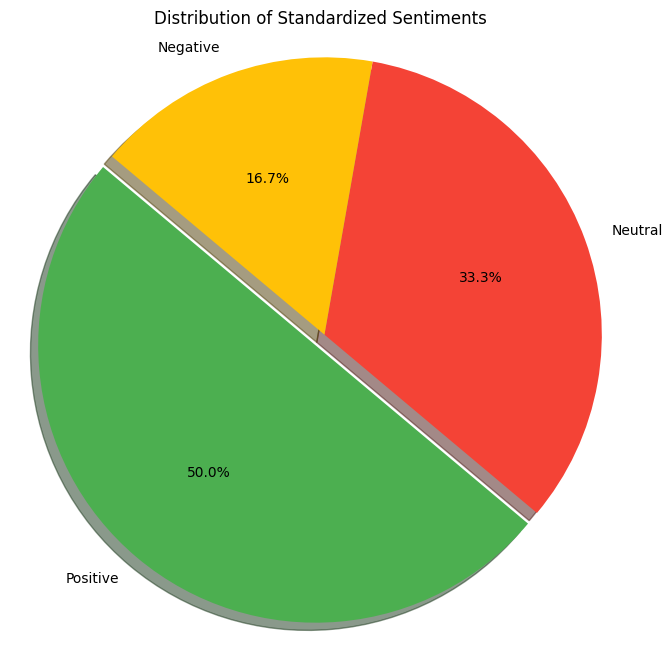

In [1]:
import pandas as pd
import io
import string
import matplotlib.pyplot as plt

def load_messy_data():
    """
    Loads the provided messy data sample into a pandas DataFrame.
    """
    
    # The messy data sample as a multi-line string
    data = """TweetID,Timestamp,Tweet_Text,Sentiment,Platform
1A,1696140000,"@MTN_Uganda your 4G is amazing! #fast",Pos,Twitter
2B,2023-10-01T09:30:00Z,"@Airtel_Ug data is sooo slow... :( #frustrated",Negative,X
3C,1696143600,"Why is my mobile money transfer failing? @StanbicUG",N/A,Twitter
4D,2023-10-01T12:15:00Z,"Just paid my @UmemeUg bill with the app, very smooth!",Positive,X
5E,1696147200,"N/A","neutral",Facebook
6F,2023-10-01T15:00:00Z,"I love the new @JumiaUG app design! #uiux",pos,Twitter
"""

    print("--- Loading data ---")
    
    # Use io.StringIO to treat the string data as if it were a file
    data_file = io.StringIO(data)
    
    # Load the data into a pandas DataFrame
    # We specify 'N/A' as a value to be treated as NaN (Not a Number / Null)
    try:
        df = pd.read_csv(data_file, na_values=["N/A"])
        
        print("DataFrame loaded successfully:")
        print(df)
        
        print("\n--- DataFrame Info (Initial Load) ---")
        # .info() shows data types and non-null counts
        df.info()
        
        return df
        
    except Exception as e:
        print(f"An error occurred while loading the data: {e}")
        return None

def preprocess_text(text):
    """
    Cleans a single text entry by removing mentions (@), hashtags (#), 
    punctuation, and converting it to lowercase. Handles NaN values gracefully.
    """
    # Check for NaN/None values before attempting string operations
    if pd.isna(text):
        return text 
    
    # Convert to string and lowercase
    text = str(text).lower()
    
    # Remove mentions (@) and hashtags (#). Replace with a space to help
    # separate words, though the surrounding context often negates this.
    text = text.replace('@', '').replace('#', '')
    
    # Remove punctuation
    # Create a translation table that maps all punctuation characters to None
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    
    return text.strip()

def clean_data(df):
    """
    Cleans the DataFrame by standardizing timestamps, text content, and sentiment.
    """
    if df is None:
        print("No DataFrame to clean.")
        return None
        
    print("\n--- Cleaning data ---")
    
    # Create a copy to avoid SettingWithCopyWarning
    df_cleaned = df.copy()
    
    # 1. Standardize Timestamp
    # Convert numeric strings/values (Unix timestamps) to datetime
    unix_timestamps = pd.to_datetime(
        pd.to_numeric(df_cleaned['Timestamp'], errors='coerce'), 
        unit='s', 
        errors='coerce'
    )
    
    # Convert string values (ISO 8601) to datetime
    iso_timestamps = pd.to_datetime(df_cleaned['Timestamp'], errors='coerce', utc=True)
    
    # Combine the two, making Unix timestamps UTC-aware
    df_cleaned['Timestamp'] = unix_timestamps.dt.tz_localize('UTC').fillna(iso_timestamps)
    
    print("\nAfter standardizing 'Timestamp':")
    print(df_cleaned[['TweetID', 'Timestamp']])

    # 2. Clean Tweet Text
    # Apply the preprocessing function to the 'Tweet_Text' column
    df_cleaned['Tweet_Text_Cleaned'] = df_cleaned['Tweet_Text'].apply(preprocess_text)

    # Show the results of text cleaning
    print("\nAfter cleaning 'Tweet_Text':")
    print(df_cleaned[['TweetID', 'Tweet_Text', 'Tweet_Text_Cleaned']])

    # 3. Standardize Sentiment
    sentiment_mapping = {
        'pos': 'Positive',
        'positive': 'Positive',
        'negative': 'Negative',
        'neg': 'Negative', 
        'neutral': 'Neutral'
    }
    
    # Convert to lowercase and map the values
    df_cleaned['Sentiment_Standardized'] = df_cleaned['Sentiment'].str.lower().map(sentiment_mapping)
    
    # Fill remaining NaN values (which originated from 'N/A' in the raw data) with 'Neutral'
    df_cleaned['Sentiment_Standardized'] = df_cleaned['Sentiment_Standardized'].fillna('Neutral')
    
    print("\nAfter standardizing 'Sentiment':")
    print(df_cleaned[['TweetID', 'Sentiment', 'Sentiment_Standardized']])

    # 4. Calculate Character Length of Cleaned Text
    # Use .str.len() to calculate the length of the string in the 'Tweet_Text_Cleaned' column.
    df_cleaned['Tweet_Length'] = df_cleaned['Tweet_Text_Cleaned'].str.len()
    
    print("\nAfter calculating 'Tweet_Length':")
    print(df_cleaned[['TweetID', 'Tweet_Text_Cleaned', 'Tweet_Length']])


    print("\n--- DataFrame Info (After Cleaning) ---")
    df_cleaned.info()
    
    return df_cleaned

def analyze_and_visualize_data(df):
    """
    Performs final analysis and generates a visualization.
    """
    if df is None:
        return
    
    print("\n--- Final Analysis and Visualization ---")
    
    # 1. Calculate Average Tweet Length by Sentiment
    avg_length_by_sentiment = df.groupby('Sentiment_Standardized')['Tweet_Length'].mean().sort_values(ascending=False)
    
    print("\nAverage Tweet Length by Standardized Sentiment:")
    print(avg_length_by_sentiment.to_string(float_format="%.2f"))
    
    # 2. Generate Pie Chart for Sentiment Distribution
    sentiment_counts = df['Sentiment_Standardized'].value_counts()
    
    if sentiment_counts.empty:
        print("\nCannot generate pie chart: No sentiment data found.")
        return
        
    labels = sentiment_counts.index
    sizes = sentiment_counts.values
    colors = ['#4CAF50', '#F44336', '#FFC107'] # Green for Positive, Red for Negative, Yellow for Neutral
    explode = (0.05, 0, 0)  # Explode the positive slice

    plt.figure(figsize=(8, 8))
    plt.pie(
        sizes, 
        explode=explode, 
        labels=labels, 
        colors=colors[:len(labels)], # Use only as many colors as needed
        autopct='%1.1f%%',
        shadow=True, 
        startangle=140
    )
    plt.title('Distribution of Standardized Sentiments')
    plt.axis('equal') # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

if __name__ == "__main__":
    # Run the function when the script is executed directly
    dataframe = load_messy_data()
    # Pass the loaded dataframe to the cleaning function
    cleaned_dataframe = clean_data(dataframe)
    # Perform final analysis and visualization
    analyze_and_visualize_data(cleaned_dataframe)